**XGBoost**

In [1]:
import pandas as pd

# Read the CSV file with a specified encoding
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

# Display the first 5 rows
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum
0,1998,1,1,2,5,1998-01-02,NW,19386,NW,N297US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,5,28,4,2009-05-28,FL,20437,FL,N946AT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,2,6,29,6,2013-06-29,MQ,20398,MQ,N665MQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,3,8,31,2,2010-08-31,DL,19790,DL,N6705Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,1,1,15,7,2006-01-15,US,20355,US,N504AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# --- Preprocessing ---
# Fill missing values for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [4]:
# Create binary target variable 'DelayCategory': 1 if there was an arrival delay (ArrDelay > 0), 0 if there wasn't
df['DelayCategory'] = df.apply(lambda row: 1 if row['ArrDelay'] > 0 else 0, axis=1)

In [6]:
# Encode 'DelayCategory'
le = LabelEncoder()
df['DelayCategory'] = le.fit_transform(df['DelayCategory'])

In [7]:
# --- Feature Engineering (Time-related and Categorical Features) ---

# Convert arrival time to minutes since midnight
df['ArrTime_combined'] = df['ArrTime'] // 100 * 60 + df['ArrTime'] % 100

# Time of day: 6 AM to 2 PM window for arrival
df['DayArrivalFlight'] = df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal features (months with higher delay rates)
df['HighDelaySeason'] = df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)

# Weekend flag (Saturday and Sunday)
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)

# Airline-based delay flag
df['HighDelayAirline'] = df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6','PS'] else 0)

# High-delay weekdays: Wednesday 
df['HighDelayWeekday'] = df['DayOfWeek'].apply(lambda x: 1 if x in [3] else 0)

# State-based flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']

df['HighDelayOriginState'] = df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
df['HighDelayDestState'] = df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# --- Aggregated Delay Rates (Historical Averages) ---
# Airline average delay rate
carrier_delay_rate = df.groupby('IATA_CODE_Reporting_Airline')['DelayCategory'].mean()
df['AirlineDelayRate'] = df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)

# Origin state average delay rate
origin_delay_rate = df.groupby('OriginState')['DelayCategory'].mean()
df['OriginStateDelayRate'] = df['OriginState'].map(origin_delay_rate)

# Destination state average delay rate
dest_delay_rate = df.groupby('DestState')['DelayCategory'].mean()
df['DestStateDelayRate'] = df['DestState'].map(dest_delay_rate)

# Weather delay rate by route (Origin-Destination pair)
df['Route'] = df['Origin'] + '-' + df['Dest']  # Combine Origin and Destination for the route
weather_delay_rate = df.groupby('Route')['WeatherDelay'].mean()
df['WeatherDelayRate'] = df['Route'].map(weather_delay_rate)

# Calculate NAS delay rate by route (Origin-Destination pair)
df['Route'] = df['Origin'] + '-' + df['Dest']  # Create a new column for Route (Origin-Destination)
# Calculate the NAS delay rate for each route
nas_delay_rate_by_route = df.groupby('Route')['NASDelay'].mean()
# Map the NAS delay rate back to the dataset
df['NASDelayRate'] = df['Route'].map(nas_delay_rate_by_route)

# Late aircraft delay rate by airline
late_aircraft_delay_rate = df.groupby('IATA_CODE_Reporting_Airline')['LateAircraftDelay'].mean()
df['LateAircraftDelayRate'] = df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)

# --- Highest Delayed Flight Number Feature ---
# Aggregate the total delay count for each Flight_Number_Reporting_Airline
flight_delay_sum = df.groupby('Flight_Number_Reporting_Airline')['DelayCategory'].sum().reset_index()

# Sort the flights by the total delay count, descending, to get the highest delayed flights first
flight_delay_sum = flight_delay_sum.sort_values(by='DelayCategory', ascending=False)

# Assign a new column with the flight numbers that have the highest delays (ranked by sum of delays)
# Create a new feature: 'HighestDelayedFlightNumber'
df['HighestDelayedFlightNumber'] = df['Flight_Number_Reporting_Airline'].map(flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory'])

# --- Final Feature Set ---

features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# Features and target
X = df[features]
y = df['DelayCategory']

In [8]:
# Label encode any object/categorical columns (just in case)
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

# Fill any remaining missing values
X = X.fillna(X.median())

# --- Standardization (important for Logistic Regression) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Handle Imbalance**

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ratio_of_classes = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# --- XGBoost model with tuned parameters ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42,
    scale_pos_weight=ratio_of_classes
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# --- Get predicted probabilities --- 
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1 (delayed flights)

# --- Set a custom threshold for classification --- 
threshold = 0.5  # You can adjust this value (0.3, 0.4, etc.)
y_pred_class = (y_pred_prob >= threshold).astype(int)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_class, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

# --- Print classification report ---
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_class))

# --- Print confusion matrix ---
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))


XGBoost F1 Score (weighted): 0.6735106668459615

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71    228089
           1       0.62      0.64      0.63    171911

    accuracy                           0.67    400000
   macro avg       0.67      0.67      0.67    400000
weighted avg       0.67      0.67      0.67    400000


XGBoost Confusion Matrix:
[[159636  68453]
 [ 62395 109516]]


**Feature Importance**

Top 10 Features by Importance:
                  Feature  Importance
6                 AirTime    0.148873
5          CRSElapsedTime    0.120365
0                    Year    0.082776
8         HighDelaySeason    0.058619
15       AirlineDelayRate    0.053208
9        DayArrivalFlight    0.053206
4               DayOfWeek    0.040498
7                Distance    0.039422
16   OriginStateDelayRate    0.037763
20  LateAircraftDelayRate    0.037335


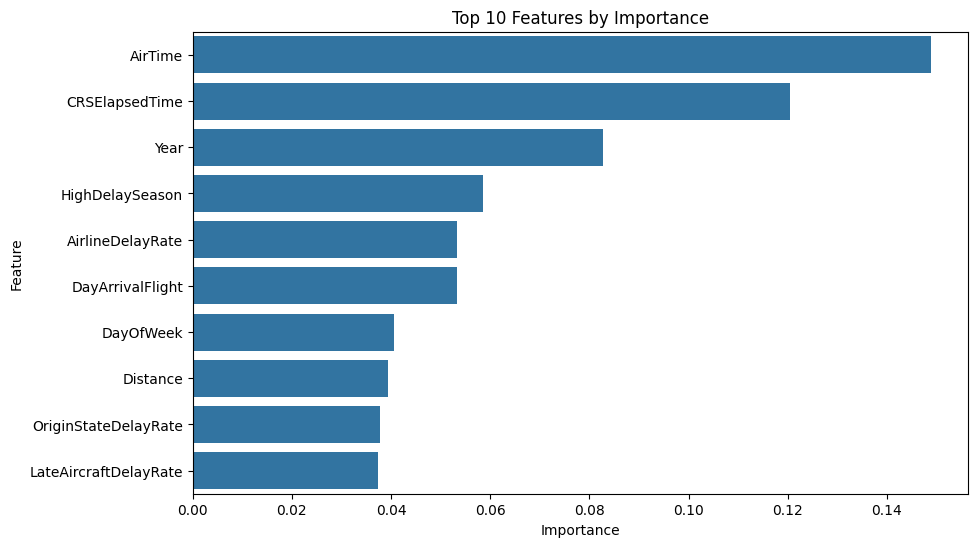

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns 

# --- Get feature importance ---
feature_importance = xgb_model.feature_importances_

# --- Sort the features by importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# --- Print the top features ---
print("Top 10 Features by Importance:")
print(importance_df.head(10))

# --- Plot feature importance using matplotlib ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Top 10 features
plt.title('Top 10 Features by Importance')
plt.show()

In [11]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary (replace these with user input values) ---
raw_input = {
    'Year': 2022,
    'Quarter': 3,
    'Month': 7,
    'DayofMonth': 15,
    'DayOfWeek': 3,
    'CRSElapsedTime': 180,
    'AirTime': 160,
    'Distance': 1000,
    'ArrTime': 930,  # 9:30 AM
    'IATA_CODE_Reporting_Airline': 'AA',
    'Origin': 'LAX',
    'Dest': 'JFK',
    'OriginState': 'CA',
    'DestState': 'NY',
    'Flight_Number_Reporting_Airline': '1234'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---

# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6','PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---

# These variables must come from training data
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.55
Prediction: Delayed


In [12]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary (replace these with user input values) ---
raw_input = {
    'Year': 2022,
    'Quarter': 3,
    'Month': 9,
    'DayofMonth': 22,
    'DayOfWeek': 1,
    'CRSElapsedTime': 180,
    'AirTime': 160,
    'Distance': 1000,
    'ArrTime': 330,  # 9:30 AM
    'IATA_CODE_Reporting_Airline': 'UA',
    'Origin': 'SEA',  # Seattle-Tacoma International Airport (Washington)
    'Dest': 'ORD',    # O'Hare International Airport (Chicago, Illinois)
    'OriginState': 'WA',  # Washington
    'DestState': 'IL',    # Illinois
    'Flight_Number_Reporting_Airline': '1234'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---

# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6','PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---

# These variables must come from training data
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.13
Prediction: On-Time


In [15]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary (replace these with user input values) ---
raw_input = {
    'Year': 2023,
    'Quarter': 2,
    'Month': 5,
    'DayofMonth': 1,
    'DayOfWeek': 3,  # Assuming it's a Thursday
    'CRSElapsedTime': 180,  # Flight time in minutes
    'AirTime': 150,  # Flight time in minutes
    'Distance': 1060,  # Distance in miles (Philadelphia to Miami)
    'ArrTime': 2111,  # Estimated arrival time in minutes (9:11 PM)
    'IATA_CODE_Reporting_Airline': 'AA',
    'Origin': 'PHL',  # Philadelphia International Airport
    'Dest': 'MIA',  # Miami International Airport
    'OriginState': 'PA',  # Pennsylvania
    'DestState': 'FL',  # Florida
    'Flight_Number_Reporting_Airline': '1181'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---

# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6','PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---
# These variables must come from training data
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.42
Prediction: On-Time


In [17]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary ---
raw_input = {
    'Year': 2025,
    'Quarter': 2,
    'Month': 4,
    'DayofMonth': 30,
    'DayOfWeek': 3,  # Wednesday
    'CRSElapsedTime': 270,  # 4h 30m
    'AirTime': 250,  # Example
    'Distance': 2000,  # Example, adjust for actual route distance
    'ArrTime': 1253,  # 12:53 PM
    'IATA_CODE_Reporting_Airline': 'BW',  # Caribbean Airlines
    'Origin': 'POS',  # Port of Spain
    'Dest': 'MCO',    # Orlando
    'OriginState': 'TT',  # Trinidad and Tobago (POS)
    'DestState': 'FL',    # Florida (MCO)
    'Flight_Number_Reporting_Airline': '482'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---

# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6','PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")


Predicted probability of delay: 0.01
Prediction: On-Time


In [20]:
import numpy as np
import pandas as pd

raw_input = {
    'Year': 2019,
    'Quarter': 4,  # December, 4th quarter of the year
    'Month': 12,
    'DayofMonth': 13,
    'DayOfWeek': 5,  # Friday
    'CRSElapsedTime': 180,  # Approximate flight duration in minutes
    'AirTime': 170,  # Actual time spent in the air
    'Distance': 1770,  # Distance in kilometers
    'ArrTime': 2055,  # 8:55 PM
    'IATA_CODE_Reporting_Airline': 'AA',
    'Origin': 'LGA',  # LaGuardia Airport, NYC
    'Dest': 'MIA',    # Miami International Airport
    'OriginState': 'NY',  # New York
    'DestState': 'FL',    # Florida
    'Flight_Number_Reporting_Airline': '1389'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---
# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'B6', 'PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---
# These variables must come from training data
# Ensure these dictionaries are defined based on your training set's mappings
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.56
Prediction: Delayed
